In [1]:
# import libs
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import skimage.io as io
import pylab
import random
from tqdm import tqdm
import time
from mrcnn.model import log
from mrcnn import visualize
import tensorflow as tf
from tensorflow import keras

/home/samy/Documents/AI/env_local/env_stage/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/samy/Documents/AI/env_local/env_stage/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/samy/Documents/AI/env_local/env_stage/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/samy/Document

In [2]:

# Root directory of the project
ROOT_DIR = os.path.abspath("./")# Import Mask RCNN
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join('./weights', "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

In [3]:
# define 81 classes that the coco model knowns about
category = 'food'
class_names = ['bread-wholemeal', 'potatoes-steamed', 'broccoli', 'butter', 
            'hard-cheese', 'water', 'banana', 'wine-white', 'bread-white', 
            'apple', 'pizza-margherita-baked', 'salad-leaf-salad-green', 
            'zucchini', 'water-mineral', 'coffee-with-caffeine', 'avocado', 
            'tomato', 'dark-chocolate', 'white-coffee-with-caffeine', 'egg', 
            'mixed-salad-chopped-without-sauce', 'sweet-pepper', 'mixed-vegetables', 
            'mayonnaise', 'rice', 'chips-french-fries', 'carrot', 'tomato-sauce', 
            'cucumber', 'wine-red', 'cheese', 'strawberries', 'espresso-with-caffeine', 
            'tea', 'chicken', 'jam', 'leaf-spinach', 'pasta-spaghetti', 'french-beans', 'bread-whole-wheat','com','bun','ga','cha lua','banh bao','goi cuan']


In [4]:

class CustomConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = category

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + len(class_names)  # Background + toy

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 20

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [5]:
############################################################
#  Dataset
############################################################

class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        # we add 6 classes
        for i in range(1,len(class_names)+1):
            self.add_class(category, i, class_names[i-1])

        # Train and validation dataset
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        coco = COCO(os.path.join(dataset_dir, 'annotations.json'))

        category_ids = coco.loadCats(coco.getCatIds())
        cat_ids = [obj['id'] for obj in category_ids]


        for catIndex in tqdm(cat_ids):
            image_ids = coco.getImgIds(catIds=catIndex) 
            for i in range(len(image_ids)):
                polygons = []
                class_ids = []

                tmp = coco.loadImgs([image_ids[i]])
                w,h = tmp[0]['width'],tmp[0]['height']
                a_image_id = image_ids[i]
                img = coco.loadImgs(a_image_id)[0] #here fetching it
                annotation_ids = coco.getAnnIds(imgIds=img['id'])
                annotations = coco.loadAnns(annotation_ids)    
                image_path = os.path.join(dataset_dir,'images/'+img['file_name'])

                #we are now inputting the polygons
                for j in range(len(annotations)):
                    all_points_x = []
                    all_points_y = []

                    for n in range(0,len(annotations[j]['segmentation'][0]),2):
                        all_points_x.append(annotations[j]['segmentation'][0][n])
                        all_points_y.append(annotations[j]['segmentation'][0][n+1])
                    polygons.append({'name':'polygon', 'all_points_x':all_points_x, 'all_points_y':all_points_y})
                    idx = cat_ids.index(annotations[j]['category_id'])
                    class_ids.append(class_names.index(category_ids[idx]['name'])+1)

                self.add_image(
                    category,  
                    image_id=img['file_name'],  
                    path=image_path,
                    width=w, height=h,
                    polygons=polygons, 
                    class_ids=class_ids)

    #TOMODIFY FROM HERE
    def load_mask(self, image_id):
        # delegate to parent class (food).
        image_info = self.image_info[image_id]
        if image_info["source"] != category:
            return super(self.__class__, self).load_mask(image_id)
        
        
        class_ids = image_info['class_ids']
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. 
        class_ids = np.array(class_ids, dtype=np.int32)
        return mask.astype(np.bool), class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == category:
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [6]:
#Model configuration set up
dataset="./dataset"
weights="coco"
config=CustomConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [7]:
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

In [8]:
 model = modellib.MaskRCNN(mode="inference", 
                           config=config,
                                  model_dir=DEFAULT_LOGS_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [11]:
# laod train dataset
dataset_train = CustomDataset()
dataset_train.load_custom("./dataset", "train")
dataset_train.prepare()

 # laod Validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom("./dataset", "val")
dataset_val.prepare()

100%|██████████| 6/6 [00:00<00:00, 688.64it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [19]:
# Training
 """Train the model."""
print("Training network heads")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=10,
            layers='heads')


In [13]:
#load weight from logs
model_path='./logs/food20200828T1533/mask_rcnn_food_0005.h5'
print(model_path)
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

./logs/food20200828T1533/mask_rcnn_food_0005.h5
Loading weights from  ./logs/food20200828T1533/mask_rcnn_food_0005.h5
Re-starting from epoch 5


image_id  37 ./dataset/val/images/bun_3.jpg
image                    shape: (333, 500, 3)         min:    0.00000  max:  251.00000  uint8
mask                     shape: (333, 500, 1)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:   42.00000  max:   42.00000  int32
bbox                     shape: (1, 4)                min:    1.00000  max:  492.00000  int32


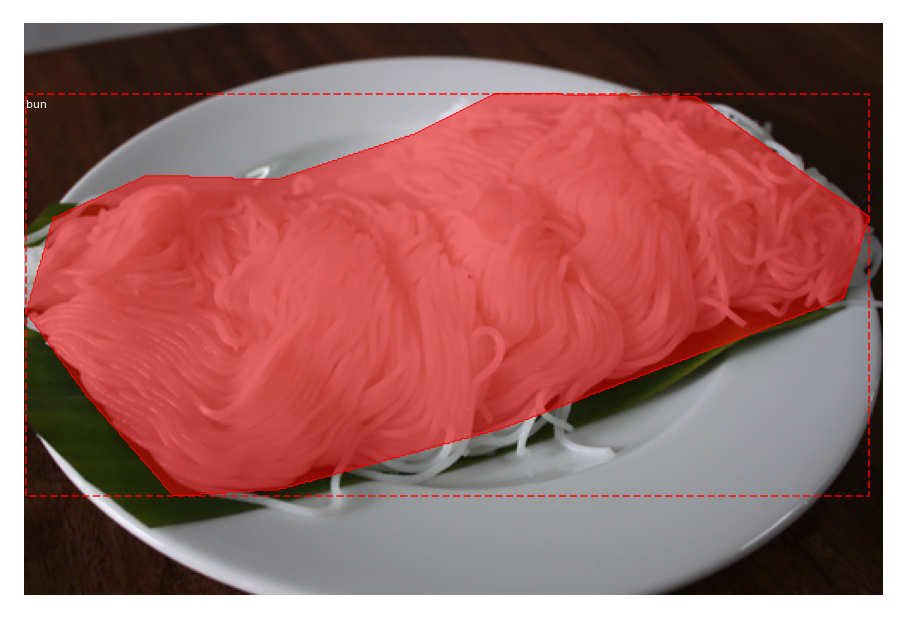

In [15]:

image_id = random.choice(dataset_val
                          .image_ids)
image = dataset_val.load_image(image_id)
mask, class_ids = dataset_val.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_val.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset_val.class_names)
original_image=image

In [16]:
plt.axis("off")
plt.imshow(image)

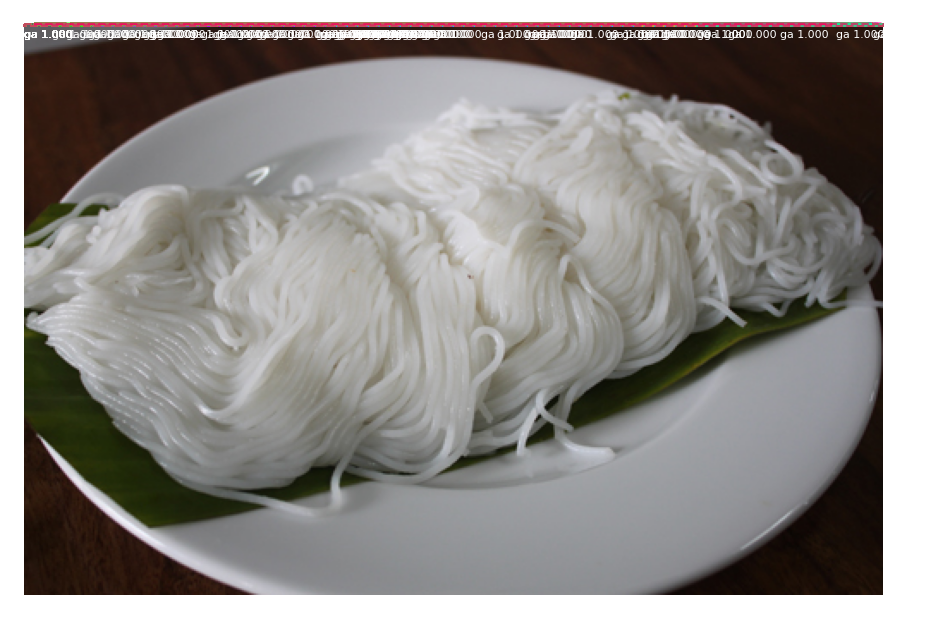

In [17]:

results = model.detect([original_image], verbose=0)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

# Evaluation of the model
We compute average precision of 120 pictures and print out the average

In [38]:
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.91


In [37]:
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001  float32
res2c_out                shape: (1, 256, 256, 256)    min:    0.00000  max:   24.41269  float32
res3c_out                shape: (1, 128, 128, 512)    min:    0.00000  max:   28.80074  float32
rpn_bbox                 shape: (1, 261888, 4)        min:   -7.34319  max:   77.24079  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


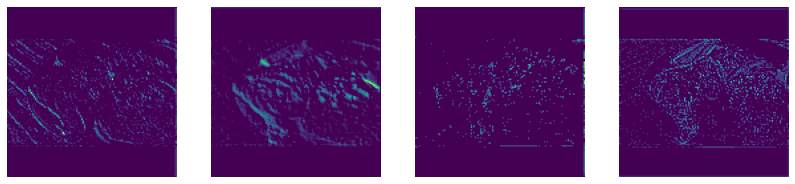

In [38]:
import numpy as np
visualize.display_images(np.transpose(activations["res3c_out"][0,:,:,:4], [2, 0, 1]), cols=4)
visualize.display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)